
# Flux point fitting

Fit spectral models to combined Fermi-LAT and IACT flux points tables.


## Prerequisites

-  Some knowledge about retrieving information from catalogs, see :doc:`/tutorials/api/catalog` tutorial.

## Context

Some high level studies do not rely on reduced datasets with their IRFs
but directly on higher level products such as flux points. This is not
ideal because flux points already contain some hypothesis for the
underlying spectral shape and the uncertainties they carry are usually
simplified (e.g. symmetric gaussian errors). Yet, this is an efficient
way to combine heterogeneous data.

**Objective: fit spectral models to combined Fermi-LAT and IACT flux
points.**

## Proposed approach

Here we will load, the spectral points from Fermi-LAT and TeV catalogs
and fit them with various spectral models to find the best
representation of the wide-band spectrum.

The central class we’re going to use for this example analysis is:

-  `~gammapy.datasets.FluxPointsDataset`

In addition we will work with the following data classes:

-  `~gammapy.estimators.FluxPoints`
-  `~gammapy.catalog.SourceCatalogGammaCat`
-  `~gammapy.catalog.SourceCatalog3FHL`
-  `~gammapy.catalog.SourceCatalog3FGL`

And the following spectral model classes:

-  `~gammapy.modeling.models.PowerLawSpectralModel`
-  `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel`
-  `~gammapy.modeling.models.LogParabolaSpectralModel`


## Setup

Let us start with the usual IPython notebook and Python imports:




In [1]:
from astropy import units as u

# %matplotlib inline
import matplotlib.pyplot as plt
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
)

In [2]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /Users/tharacaba/miniconda3/envs/gammapy-1.3/bin/python 
	python_version         : 3.11.11    
	machine                : arm64      
	system                 : Darwin     


Gammapy package:

	version                : 1.3        
	path                   : /Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy 


Other packages:

	numpy                  : 2.1.3      
	scipy                  : 1.14.1     
	astropy                : 6.1.6      
	regions                : 0.10       
	click                  : 8.1.8      
	yaml                   : 6.0.2      
	IPython                : 8.27.0     
	jupyterlab             : 4.2.7      
	matplotlib             : 3.9.4      
	pandas                 : 2.2.3      
	healpy                 : 1.18.0     
	iminuit                : 2.30.1     
	sherpa                 : not installed 
	naima                  : 0.10.2     
	emcee                  : 3.1.6      
	corner                 : 2.2.3   

## Load spectral points

For this analysis we choose to work with the source ‘HESS J1507-622’ and
the associated Fermi-LAT sources ‘3FGL J1506.6-6219’ and ‘3FHL
J1507.9-6228e’. We load the source catalogs, and then access source of
interest by name:




In [3]:
catalog_3fgl = CATALOG_REGISTRY.get_cls("3fgl")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()

source_fermi_3fgl = catalog_3fgl["3FGL J1506.6-6219"]
source_fermi_3fhl = catalog_3fhl["3FHL J1507.9-6228e"]
source_gammacat = catalog_gammacat["HESS J1507-622"]

The corresponding flux points data can be accessed with ``.flux_points``
attribute:




In [4]:
dataset_gammacat = FluxPointsDataset(data=source_gammacat.flux_points, name="gammacat")
dataset_gammacat.data.to_table(sed_type="dnde", formatted=True)

dataset_3fgl = FluxPointsDataset(data=source_fermi_3fgl.flux_points, name="3fgl")
dataset_3fgl.data.to_table(sed_type="dnde", formatted=True)

dataset_3fhl = FluxPointsDataset(data=source_fermi_3fhl.flux_points, name="3fhl")
dataset_3fhl.data.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_errp,dnde_errn,dnde_ul,sqrt_ts,is_ul
GeV,GeV,GeV,1 / (GeV s cm2),1 / (GeV s cm2),1 / (GeV s cm2),1 / (GeV s cm2),,
float64,float64,float64,float64,float64,float64,float64,float32,bool
14.142,10.000,20.000,9.288e-12,2.343e-12,2.128e-12,nan,5.660,False
31.623,20.000,50.000,2.777e-12,6.572e-13,5.818e-13,nan,6.940,False
86.603,50.000,150.000,2.335e-13,1.055e-13,8.554e-14,nan,3.835,False
273.861,150.000,500.000,6.411e-14,2.697e-14,2.133e-14,nan,5.697,False
1000.000,500.000,2000.000,9.188e-21,4.034e-15,nan,8.068e-15,0.000,True


## Power Law Fit

First we start with fitting a simple
`~gammapy.modeling.models.PowerLawSpectralModel`.




In [5]:
pwl = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spectral_model=pwl, name="j1507-pl")

After creating the model we run the fit by passing the ``flux_points``
and ``model`` objects:




In [6]:
datasets = Datasets([dataset_gammacat, dataset_3fgl, dataset_3fhl])
datasets.models = model
print(datasets)

fitter = Fit()
result_pwl = fitter.run(datasets=datasets)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : gammacat
  Instrument : 
  Models     : ['j1507-pl']

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : 3fgl
  Instrument : 
  Models     : ['j1507-pl']

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : 3fhl
  Instrument : 
  Models     : ['j1507-pl']




And print the result:




In [7]:
print(result_pwl)

print(model)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 40
	total stat : 28.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

SkyModel

  Name                      : j1507-pl
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      1.985   +/-    0.03             
    amplitude                     :   1.28e-12   +/- 1.6e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         




Finally we plot the data points and the best fit model:




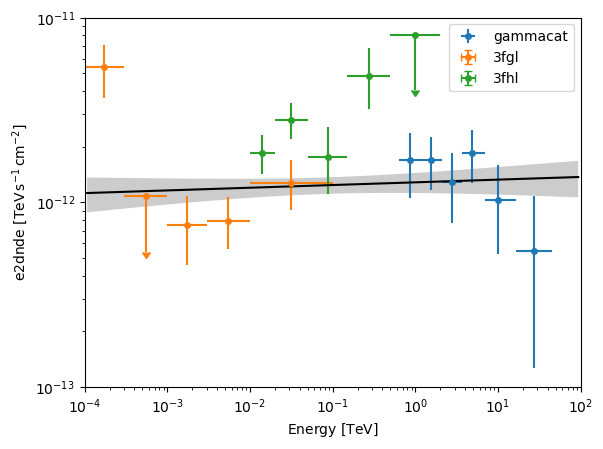

In [8]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-4, 1e2] * u.TeV
pwl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
pwl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-13, 1e-11)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

## Exponential Cut-Off Powerlaw Fit

Next we fit an
`~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel` law to the
data.




In [9]:
ecpl = ExpCutoffPowerLawSpectralModel(
    index=1.8,
    amplitude="2e-12 cm-2 s-1 TeV-1",
    reference="1 TeV",
    lambda_="0.1 TeV-1",
)
model = SkyModel(spectral_model=ecpl, name="j1507-ecpl")

We run the fitter again by passing the flux points and the model
instance:




In [10]:
datasets.models = model
result_ecpl = fitter.run(datasets=datasets)
print(model)

SkyModel

  Name                      : j1507-ecpl
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      1.894   +/-    0.05             
    amplitude                     :   1.96e-12   +/- 3.9e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.078   +/-    0.05 1 / TeV     
    alpha                 (frozen):      1.000                   




We plot the data and best fit model:




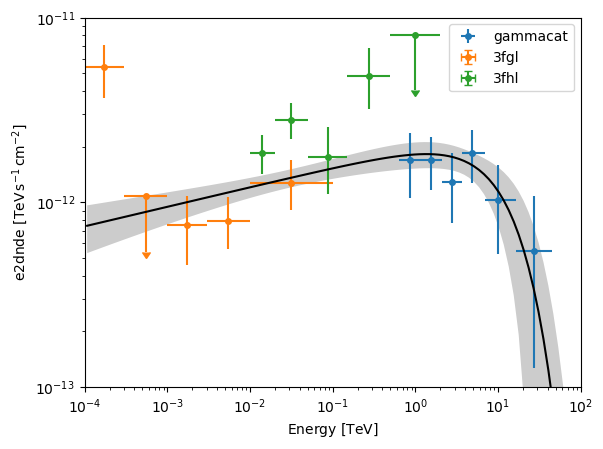

In [11]:
ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

ecpl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
ecpl.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-13, 1e-11)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

## Log-Parabola Fit

Finally we try to fit a
`~gammapy.modeling.models.LogParabolaSpectralModel` model:




SkyModel

  Name                      : j1507-lp
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.88e-12   +/- 2.8e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.144   +/-    0.07             
    beta                          :      0.049   +/-    0.02             




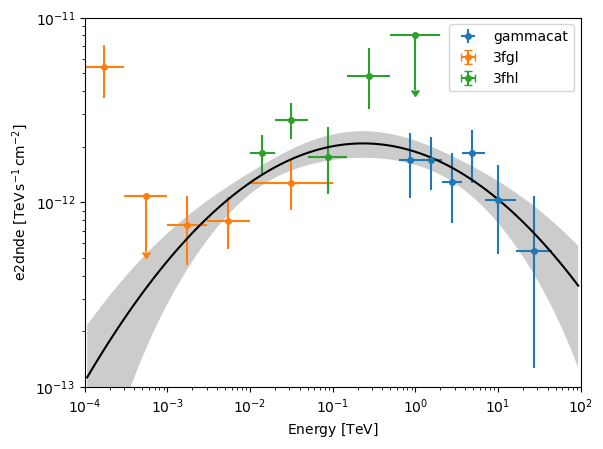

In [12]:
log_parabola = LogParabolaSpectralModel(
    alpha=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", beta=0.1
)
model = SkyModel(spectral_model=log_parabola, name="j1507-lp")

datasets.models = model
result_log_parabola = fitter.run(datasets=datasets)
print(model)

ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

log_parabola.plot(energy_bounds=energy_bounds, color="k", **kwargs)
log_parabola.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-13, 1e-11)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

## Exercises

-  Fit a `~gammapy.modeling.models.PowerLaw2SpectralModel` and
   `~gammapy.modeling.models.ExpCutoffPowerLaw3FGLSpectralModel` to
   the same data.
-  Fit a `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel`
   model to Vela X (‘HESS J0835-455’) only and check if the best fit
   values correspond to the values given in the Gammacat catalog




SkyModel

  Name                      : j1507-lp
  Datasets names            : None
  Spectral model type       : PowerLaw2SpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.26e-11   +/- 1.4e-12 1 / (s cm2) 
    index                         :      1.985   +/-    0.03             
    emin                  (frozen):      0.100       TeV         
    emax                  (frozen):    100.000       TeV         




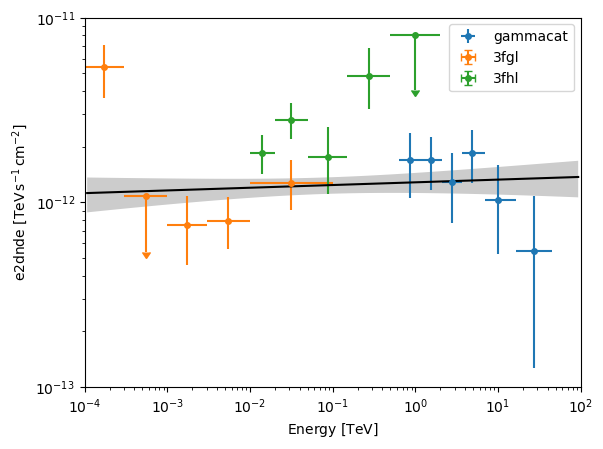

In [16]:
#Fitting PowerLaw2
from gammapy.modeling.models import PowerLaw2SpectralModel

power_law2 = PowerLaw2SpectralModel(index=2)
model = SkyModel(spectral_model=power_law2, name="j1507-lp")

datasets.models = model
result_power_law2 = fitter.run(datasets=datasets)
print(model)

ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

power_law2.plot(energy_bounds=energy_bounds, color="k", **kwargs)
power_law2.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-13, 1e-11)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

SkyModel

  Name                      : j1507-lp
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLaw3FGLSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      1.895   +/-    0.05             
    amplitude                     :   1.82e-12   +/- 2.9e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    ecut                          :     12.935   +/-    8.74 TeV         




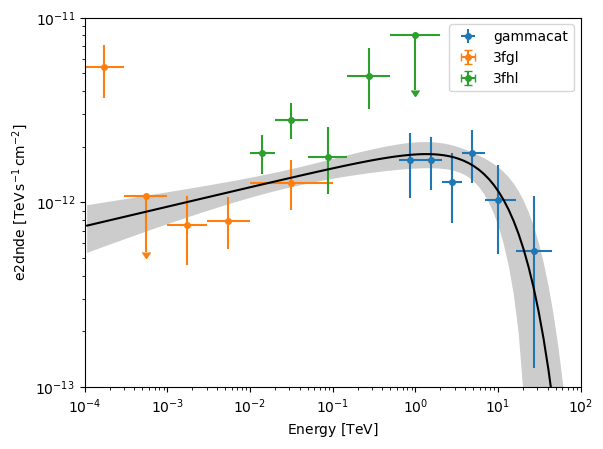

In [17]:
#Fitting ExpCutoffPowerLaw3FGL

from gammapy.modeling.models import ExpCutoffPowerLaw3FGLSpectralModel

ecopl3 = ExpCutoffPowerLaw3FGLSpectralModel()
model = SkyModel(spectral_model=ecopl3, name="j1507-lp")

datasets.models = model
result_ecopl3 = fitter.run(datasets=datasets)
print(model)

ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

ecopl3.plot(energy_bounds=energy_bounds, color="k", **kwargs)
ecopl3.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.set_ylim(1e-13, 1e-11)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : gammacat
  Instrument : 
  Models     : ['J0835-ecpl']


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 167
	total stat : 35.01

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

SkyModel

  Name                      : J0835-ecpl
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      1.353   +/-    0.06             
    amplitude                     :   1.17e-11   +/- 6.3e-13 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.076   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000           

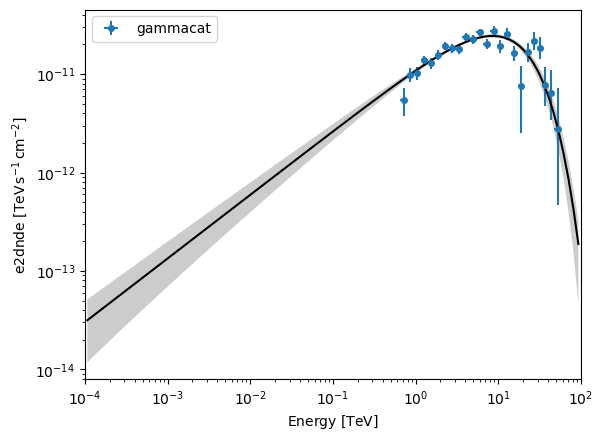

In [21]:
#Fitting the model to Vela X

source_gammacat = catalog_gammacat["HESS J0835-455"]

dataset_gammacat = FluxPointsDataset(data=source_gammacat.flux_points, name="gammacat")
dataset_gammacat.data.to_table(sed_type="dnde", formatted=True)

ecpl = ExpCutoffPowerLawSpectralModel(
    index=1.8,
    amplitude="2e-12 cm-2 s-1 TeV-1",
    reference="1 TeV",
    lambda_="0.1 TeV-1",
)
model = SkyModel(spectral_model=ecpl, name="J0835-ecpl")

datasets = Datasets([dataset_gammacat])
datasets.models = model
print(datasets)

fitter = Fit()
result_ecpl = fitter.run(datasets=datasets)

print(result_ecpl)

print(model)

ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

ecpl.plot(energy_bounds=energy_bounds, color="k", **kwargs)
ecpl.plot_error(energy_bounds=energy_bounds, **kwargs)
#ax.set_ylim(1e-13, 1e-11)
ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

## What next?

This was an introduction to SED fitting in Gammapy.

-  If you would like to learn how to perform a full Poisson maximum
   likelihood spectral fit, please check out the
   :doc:`/tutorials/analysis-1d/spectral_analysis` tutorial.
-  To learn how to combine heterogeneous datasets to perform a
   multi-instrument forward-folding fit see the
   :doc:`/tutorials/analysis-3d/analysis_mwl` tutorial.


